## Gradient Based Visualizations and Explainations


In this notebook, we are going to look at more explainations with better and much more interesting visualization via Gradient Based Visualizations.


A lot of credit for this notebook goes to [Leslie Tang](https://leslietj.github.io/) whose awesome and exceptional blog posts influence me to work on my own gradient based visualization work.


#### Importing packages


In [1]:
## Importing necessary packages ##

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import alexnet, AlexNet_Weights

from torchvision.utils import make_grid

import torchvision.transforms.functional as TF

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np


We are going to use Alexnet for our visualization backbone.


### Gradient based Saliency Maps


The first type of visualization we are going to do are **saliency maps** which shows the gradient of the output class w.r.t the input image.


#### Loading the Model


In [2]:
## Setting weights ##

weights = AlexNet_Weights.IMAGENET1K_V1

## Loading model ##

alexnet_model = alexnet(weights=weights, progress=True)

## Setting the model to eval mode ##

alexnet_model.eval()

## Vgg transformation ##

augmentation = weights.transforms()


Now lets setup our hook class, which would connect the backward hook to the image showcasing which part of the image are most important.


#### Setting Hook class


Before we setup the class, we must decide on the main overview that makes everything possible.

- The major aspect of this method working is to set the image to have gradient, i.e., setting `img.requres_grad_()`. This as such will tell the network to calculate the gradient w.r.t the input too.

- The second aspect is that there is no loss function involved. But to get the **gradients** we must do `.backward()` call. So, on what shall we do this? The answer is we should do it on the logit layers and not consider any loss function. Now if you just call `.backward()` on the logit layer's output, there will be an error, since the `.backward()` somewhat expects a scaler on which it is called. Now, since the logit layer's output will actually be a _vector_ we must be careful about how to do this. Im fact we can actually call `.backward()` on a _vector_ by passing the something as the previous gradient. The way to do this is via the `gradient` argument to the `.backward()`. But what should be this gradient? Well for our work it is a pseudo gradient which is nothing but all zeros except for the location as which the maximum logit is found (i.e. the location of the predicted class index).

- The third aspect, which for me was a bit confusing was the use of `register_module_full_backward_hook(some_hook_function)`. The thing is even though it is written as `register_module_full_backward_hook(some_hook_function)`, to actually use it on a module like `nn.Conv2d`, you must instead use `register_full_backward_hook`. (I had to remove the `_module` bit from it. It was not at all concretely written in the documentation. )

- The fourth aspect is the `hook_function` that needs to be passed to the `register_module_full_backward_hook(hook_function)`. The `hook_function` takes in three things as arguments -> `module`, `grad_inp` and `grad_out`. The thing to remember here is that both `grad_inp` and `grad_out` are tuples and the gradient are stored as the first element of the tuple. So to actually get the gradient values one must index to it using the indexing operation. Also as a side note, the `grad_inp` is the gradient w.r.t the input of the layer and `grad_out` is the gradient w.r.t the output (This was something which confused me, since I thought that `grad_inp` was the gradient coming to the layer and `gradient_out` was the gradient coming out of the layer, reversing the actual meaning.)


In [3]:
## Setup hook ##


class Hook:
    def __init__(self, model):
        """Constructor.

        Parameters
        ----------
        model : torch.nn.Module
            The model in evaluation state.
        """

        # Saving the model as a class attribute
        self.model = model

        # Contained for the final gradient map
        self.gradient_map = None

    def make_gradient_map(self, img):
        """Creates gradient map

        Parameters
        ----------
        img : torch.tensor
            The image transformed to a tensor
            of shape [B,C,H,W]
        """

        def backward_hook(module, grad_input, grad_output):

            # Saving the gradient w.r.t the inp
            self.gradient_map = grad_input[0]

        layers = self.model.features

        for layer in layers:
            if isinstance(layer, nn.ReLU):
                layer.inplace = False

        # Putting backward hook on the first layer
        layers[0].register_full_backward_hook(backward_hook)

        # Getting the output
        out = self.model(img)

        # Making pseudo gradient
        pseudo_gradient = torch.zeros_like(out)
        pseudo_gradient[:, int(torch.argmax(out).item())] = 1

        # Calling backward
        out.backward(gradient=pseudo_gradient)

    def visualize(self, vis_img):
        """Visualize the vis_img

        vis_img : torch.tensor
            It is the gradient image to be viewed.
            Considered to be shape [B,C,H,W].
        """

        # Normalization
        vis_img = (vis_img - torch.min(vis_img)) / (
            torch.max(vis_img) - torch.min(vis_img)
        )

        # Visualization
        plt.imshow(vis_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
        plt.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        plt.show()

    def __call__(self, img):
        """The call method."""
        self.make_gradient_map(img)
        self.visualize(self.gradient_map)


#### Loading Test Image


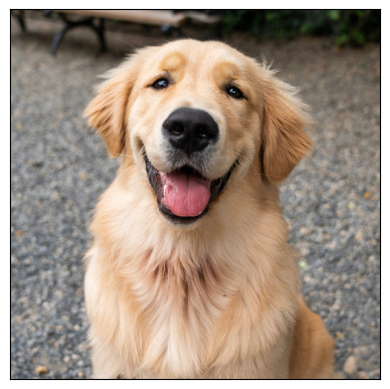

In [4]:
## Loading image via PIL and showing it ##

img = Image.open("dog.jpg")

plt.imshow(img)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.show()


In [5]:
## Preprocessing the input ##

inp = augmentation(img)
inp = inp.unsqueeze(0).requires_grad_()
print(f"Input shape is : {inp.shape}")


Input shape is : torch.Size([1, 3, 224, 224])


#### Setting Hook and visualizing the gradient


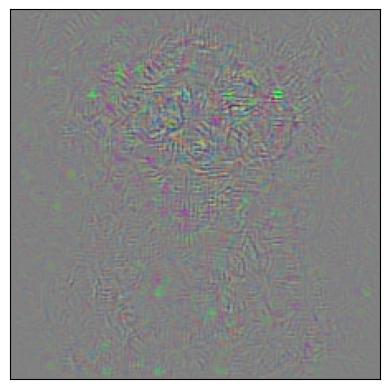

In [6]:
hook = Hook(model=alexnet_model)

hook(inp)


We can already see what part of the image the model is focusing on to make its prediction and it somewhat resembles the dog's fur and the nose. But to be honest, the saliency map, even though showcases that the model points to the correct locations, doesn't provide much clearer details and the image for me feels too shabby.


### DeconvNets based Saliency Maps


The previous visualization gave us an idea that the neural network was actually checking the correct locations in the image. But it is not so clear. Here, comes the next and a bit better concept of DeconvNets. Here the places where the relu activation function is there, the gradients w.r.t the input is calculated by zeroing out all the gradients w.r.t. the output which are less than 0 to 0 and passing all the other gradients through.


For the purposes of error-freeness I will reload the model and the image.


In [7]:
## Setting weights ##

weights_deconv = AlexNet_Weights.IMAGENET1K_V1

## Loading model ##

alexnet_model_deconv = alexnet(weights=weights_deconv, progress=True)

## Setting the model to eval mode ##

alexnet_model_deconv.eval()

## Vgg transformation ##

augmentation_deconv = weights_deconv.transforms()


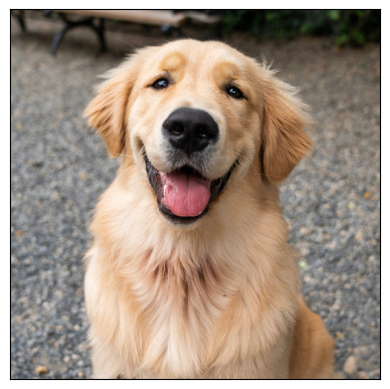

In [8]:
## Loading image via PIL and showing it ##

img_deconv = Image.open("dog.jpg")

plt.imshow(img_deconv)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.show()


In [9]:
## Preprocessing the input ##

inp_deconv = augmentation_deconv(img)
inp_deconv = inp_deconv.unsqueeze(0).requires_grad_()
print(f"Input shape is : {inp_deconv.shape}")


Input shape is : torch.Size([1, 3, 224, 224])


In [10]:
## Setting up Hook for DeconvNets ##


class DeconvNetHook:
    def __init__(self, model):
        """Constructor.

        Parameters
        ----------
        model : torch.nn.Module
            The model in evaluation state.
        """

        # Saving the model as a class attribute
        self.model = model

        # Contained for the final gradient map
        self.gradient_map = None

    def make_gradient_map(self, img):
        """Creates gradient map

        Parameters
        ----------
        img : torch.tensor
            The image transformed to a tensor
            of shape [B,C,H,W]
        """

        def first_conv_layer_backward_hook(module, grad_input, grad_output):
            self.gradient_map = grad_input[0]

        def relu_backward_hook(module, grad_input, grad_output):
            grad_inp = torch.clamp(grad_output[0], min=0.0)

            return (grad_inp,)

        layers = self.model.features
        for layer in layers:
            if isinstance(layer, nn.ReLU):
                layer.inplace = False
                layer.register_full_backward_hook(relu_backward_hook)

        layers[0].register_full_backward_hook(first_conv_layer_backward_hook)

        # Getting the output
        out = self.model(img)

        # Making pseudo gradient
        pseudo_gradient = torch.zeros_like(out)
        pseudo_gradient[:, int(torch.argmax(out).item())] = 1

        # Calling backward
        out.backward(gradient=pseudo_gradient)

    def visualize(self, vis_img):
        """Visualize the vis_img

        vis_img : torch.tensor
            It is the gradient image to be viewed.
            Considered to be shape [B,C,H,W].
        """

        # Normalization
        vis_img = (vis_img - torch.min(vis_img)) / (
            torch.max(vis_img) - torch.min(vis_img)
        )

        # Visualization
        plt.imshow(vis_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
        plt.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        plt.show()

    def __call__(self, img):
        """The call method."""
        self.make_gradient_map(img)
        self.visualize(self.gradient_map)


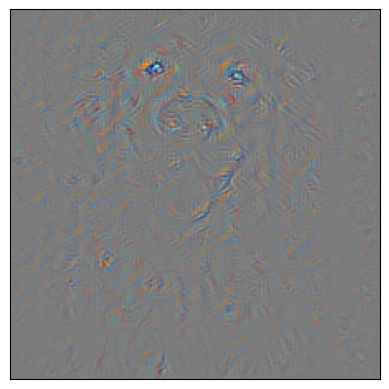

In [11]:
hook = DeconvNetHook(model=alexnet_model_deconv)

hook(inp_deconv)


### Guided Backpropagation based Saliency Maps


Even though DeconvNets gave nice explainable maps with prominent focus on the eyes and the nose of the dog but it still looks a bit noisy. This is where Guided Backpropagation comes into picture which takes into account both the goods of Vanilla gradient saliency maps and the deconvnet architectures.


Guided Backpropagation zeros out all the negative gradient coming from the later layers as well as zeros out all the gradient indices where the input in the forward pass was less than zero.


In [12]:
## Setting weights ##

weights_guided = AlexNet_Weights.IMAGENET1K_V1

## Loading model ##

alexnet_model_guided = alexnet(weights=weights_guided, progress=True)

## Setting the model to eval mode ##

alexnet_model_guided.eval()

## Vgg transformation ##

augmentation_guided = weights_guided.transforms()


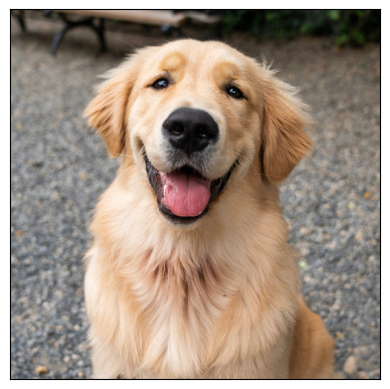

In [13]:
## Loading image via PIL and showing it ##

img_guided = Image.open("dog.jpg")

plt.imshow(img_guided)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.show()


In [14]:
## Preprocessing the input ##

inp_guided = augmentation_guided(img)
inp_guided = inp_guided.unsqueeze(0).requires_grad_()
print(f"Input shape is : {inp_guided.shape}")


Input shape is : torch.Size([1, 3, 224, 224])


In [15]:
## Setting up Hook for GuidedBackprop ##


class GuidedBackPropHook:
    def __init__(self, model):
        """Constructor.

        Parameters
        ----------
        model : torch.nn.Module
            The model in evaluation state.
        """

        # Saving the model as a class attribute
        self.model = model

        # Contained for the final gradient map
        self.gradient_map = None

        # Container for the relu activation map
        self.activation_map = []

    def make_gradient_map(self, img):
        """Creates gradient map

        Parameters
        ----------
        img : torch.tensor
            The image transformed to a tensor
            of shape [B,C,H,W]
        """

        def first_conv_layer_backward_hook(module, grad_input, grad_output):
            self.gradient_map = grad_input[0]

        def relu_forward_hook(module, inp, out):
            self.activation_map.append(inp[0])

        def relu_backward_hook(module, grad_input, grad_output):
            f = self.activation_map.pop()
            f_mask = f > 0
            grad_inp = f_mask * torch.clamp(grad_output[0], min=0.0)

            return (grad_inp,)

        layers = self.model.features
        for layer in layers:
            if isinstance(layer, nn.ReLU):
                layer.inplace = False
                layer.register_forward_hook(relu_forward_hook)
                layer.register_full_backward_hook(relu_backward_hook)

        layers[0].register_full_backward_hook(first_conv_layer_backward_hook)

        # Getting the output
        out = self.model(img)

        # Making pseudo gradient
        pseudo_gradient = torch.zeros_like(out)
        pseudo_gradient[:, int(torch.argmax(out).item())] = 1

        # Calling backward
        out.backward(gradient=pseudo_gradient)

    def visualize(self, vis_img):
        """Visualize the vis_img

        vis_img : torch.tensor
            It is the gradient image to be viewed.
            Considered to be shape [B,C,H,W].
        """

        # Normalization
        vis_img = (vis_img - torch.min(vis_img)) / (
            torch.max(vis_img) - torch.min(vis_img)
        )

        # Visualization
        plt.imshow(vis_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
        plt.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        plt.show()

    def __call__(self, img):
        """The call method."""
        self.make_gradient_map(img)
        self.visualize(self.gradient_map)


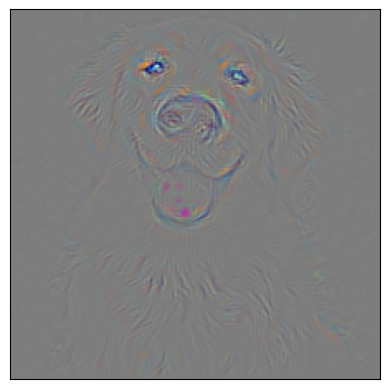

In [16]:
hook = GuidedBackPropHook(model=alexnet_model_deconv)

hook(inp_guided)


As you can see this looks way cleaner and less noisy.

One thing to note is that both Guided Backpropagation and the Deconvnet manipulates the gradient of the ReLU activation. This simple trick gives such vivid result.


### Grad-CAM based Saliency Maps


The last and the final exploration of visualization we are going to do is that of Grad-CAM which are touted as the current state of the art for visualization. We are going to again implement it and see how it works.


GradCAM is somewhat different from what we did previously since in GradCAM the gradient of the final conv layer is manipulated to showcase what it has learnt.

In GradCAM the gradient w.r.t the last conv layer is taken and mean over the spatial dimensions is done to make a mean map for each of the filter channels of the activation map. These are called _weights_. These weights are then multiplied channel wise with the activation from this last conv layer and summed across the channels, to make a heatmap.

Moreover for fine grained visualization, the GradCAM based heatmaps are resized to match the original image and it is element wise multiplied with the Guided Backpropagation gradient map w.r.t the input image to fetch a much finer and detailed gradient.


Again for the purposes of error free code, we are going to re-instantiate the AlexNet model and the image.


In [17]:
## Setting weights ##

weights_gradcam = AlexNet_Weights.IMAGENET1K_V1

## Loading model ##

alexnet_model_gradcam = alexnet(weights=weights_gradcam, progress=True)

## Setting the model to eval mode ##

alexnet_model_gradcam.eval()

## Vgg transformation ##

augmentation_gradcam = weights_gradcam.transforms()


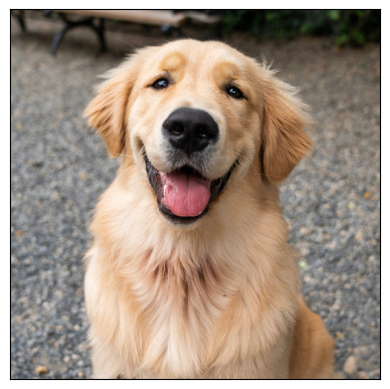

In [18]:
## Loading image via PIL and showing it ##

img_gradcam = Image.open("dog.jpg")

plt.imshow(img_gradcam)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.show()


In [19]:
## Preprocessing the input ##

inp_gradcam = augmentation_gradcam(img)
inp_gradcam = inp_gradcam.unsqueeze(0).requires_grad_()
print(f"Input shape is : {inp_gradcam.shape}")


Input shape is : torch.Size([1, 3, 224, 224])


In [20]:
## Setting up Hook for DeconvNets ##


class GradCamHook:
    def __init__(self, model):
        """Constructor.

        Parameters
        ----------
        model : torch.nn.Module
            The model in evaluation state.
        """

        # Saving the model as a class attribute
        self.model = model

        # Contained for the final heat map
        self.heatmap = None

        # Container for the last conv activation map
        self.activation_map = None

        # Container for relu activation maps
        self.relu_activation_map = []

        # Gradient map
        self.gradient_map = None

    def make_heatmap(self, img):
        """Creates heat map

        Parameters
        ----------
        img : torch.tensor
            The image transformed to a tensor
            of shape [B,C,H,W]
        """

        def conv_forward_hook(module, inp, out):
            self.activation_map = inp[0]

        def conv_backward_hook(module, grad_input, grad_output):
            grad_weights = grad_output[0].mean(dim=(-2, -1), keepdims=True)
            self.heatmap = F.relu((grad_weights * self.activation_map).sum(dim=1))

        def first_conv_layer_backward_hook(module, grad_input, grad_output):
            self.gradient_map = grad_input[0]

        def relu_forward_hook(module, inp, out):
            self.relu_activation_map.append(inp[0])

        def relu_backward_hook(module, grad_input, grad_output):
            f = self.relu_activation_map.pop()
            f_mask = f > 0
            grad_inp = f_mask * torch.clamp(grad_output[0], min=0.0)

            return (grad_inp,)

        layers = self.model.features

        layers[0].register_full_backward_hook(first_conv_layer_backward_hook)

        last_conv_layer = self.model.features[10]
        last_conv_layer.register_forward_hook(conv_forward_hook)
        last_conv_layer.register_full_backward_hook(conv_backward_hook)

        for layer in layers:
            if isinstance(layer, nn.ReLU):
                layer.inplace = False
                layer.register_forward_hook(relu_forward_hook)
                layer.register_full_backward_hook(relu_backward_hook)

        # Getting the output
        out = self.model(img)

        # Making pseudo gradient
        pseudo_gradient = torch.zeros_like(out)
        pseudo_gradient[:, int(torch.argmax(out).item())] = 1

        # Calling backward
        out.backward(gradient=pseudo_gradient)

    def visualize(self, vis_heatmap_tensor, img=None, guided=True):
        """Visualize the vis_img

        vis_heatmap_img : torch.tensor
            It is the gradcam heatmap tensor.
            Considered to be shape [B,H,W].
        img : PIL.Image
            The original PIL image. Needed in case you want
            to overlay the heatmap on the original image.

        guided : bool
            Flag when set to True shows the guided gradcam result.
        """

        # Visualization

        if img != None:
            vis_heatmap_tensor = (
                vis_heatmap_tensor - torch.min(vis_heatmap_tensor)
            ) / (torch.max(vis_heatmap_tensor) - torch.min(vis_heatmap_tensor))
            vis_heatmap = cv2.resize(
                vis_heatmap_tensor.squeeze(0).numpy(), (img.size[0], img.size[1])
            )
            vis_heatmap = np.uint8(255 * vis_heatmap)
            vis_heatmap = cv2.applyColorMap(vis_heatmap, cv2.COLORMAP_JET)
            img = np.asarray(img)
            vis_heatmap = cv2.addWeighted(img, 0.6, vis_heatmap, 0.4, 0)
            vis_heatmap = cv2.cvtColor(vis_heatmap, cv2.COLOR_BGR2RGB)
            vis_heatmap = (vis_heatmap - np.min(vis_heatmap)) / (
                np.max(vis_heatmap) - np.min(vis_heatmap)
            )
            plt.imshow(vis_heatmap)
            plt.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
                bottom=False,
            )
            plt.show()

        if guided:
            vis_heatmap = TF.resize(
                vis_heatmap_tensor,
                (self.gradient_map.shape[-2], self.gradient_map.shape[-1]),
            )
            vis_heatmap = vis_heatmap.expand_as(self.gradient_map)
            vis_heatmap = vis_heatmap * self.gradient_map
            vis_heatmap = vis_heatmap.squeeze(0).permute(1, 2, 0)
            vis_heatmap = vis_heatmap.numpy()
            vis_heatmap = (vis_heatmap - np.min(vis_heatmap)) / (
                np.max(vis_heatmap) - np.min(vis_heatmap)
            )
            plt.imshow(vis_heatmap)
            plt.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
                bottom=False,
            )
            plt.show()

    def __call__(self, img_tensor, img=None, guided=True):
        """The call method."""
        self.make_heatmap(img_tensor)
        self.visualize(self.heatmap, img, guided=guided)


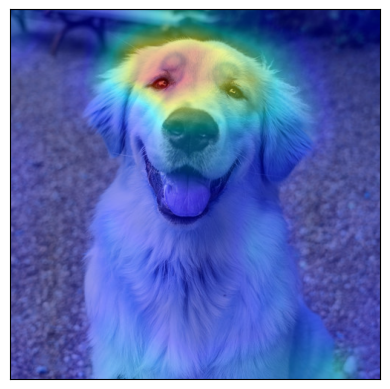

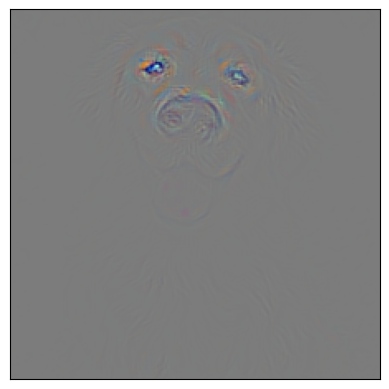

In [21]:
## Grad Cam ##

hook = GradCamHook(model=alexnet_model_deconv)

hook(inp_gradcam, img_gradcam, True)


Wow... As you can see the Grad-CAM visualizations are exceptional and can be cultivated for far more richer representation and understanding.

With this I want to take a stop at this long notebook and hope the content is adequate enough for explainability.